# AI Explorer Model Training and Evaluation Notebook


 #### Table of Contents
1. Introduction
2. Data Preparation
    * 1.1 Read in the datasets  
    * 1.2 Quality Checks
1. Exploratory Data Analysis
   * 2.1 Check for Class Imbalance
   * 2.2 Check Distributions of Demographic Variables
3. Defining Cohorts
4. Modeling: Example with Cohort A: raw diagnosis and procedure codes   
   * 4.1 Logistic Models
        * 4.1.a Data Preparation 
        * 4.1.b Baseline Logistic Model
    * 4.2 Regularized Logistic Model
    * 4.3 XGBoost Model
    * 4.4 Compare Models
5. Run Models on rest of cohorts  
    * 5.1 Cohort A: Grouped Codes
    * 5.2 Cohort B: Raw Codes
    * 5.3 Cohort B: Grouped Codes
6. Conclusion

***

<a id="1"></a> 
## Introduction

**Domain Background**

This notebook is second out of two notebooks that utilizes the beneficiary and provider data sources in the Integrated Data Repository (IDR) – a high-volume data warehouse integrating Parts A, B, C, D, and DME claims – to build a predictive algorithm to identify beneficiaries likely to have an inpatient hospitalization occur within approximately 3 months.
 
 

**Datasets and Inputs**

The other jupyter notebook `cohort_outcome_clinical_elements_selection.ipynb` contains the snowflake SQL code passed through a driver package to create the four CSV files we will use in our modeling efforts. The description of each of the datatables is below:

Table: CSV File Descriptions

<style>
    .heatMap {
        width: 90%;
        text-align: left;
    }
    .heatMap th {
        background: white;
        word-wrap: break-word;
        text-align: center;
    }
</style>

<div class="heatMap">

| Table | Description | 
| -- | -- | 
| COHORT_A_OUTCOME | data table containing the cohort demographic variables and outcome  | 
| COHORT_A_DX_T | data table containing the array of ICD-10 codes for each beneficiary  |
| COHORT_A_PROC_T | data table containing the array of HCPC codes | 
| COHORT_A_RX_T | data table containing the array of Rx codes | 
</div>

The outcome variable is **UNPLANNED_ADMISSION** and is a binary variable if the Beneficiary had an inpatient hospitalization in the first 3 months of 2019. The definition of an "unplanned" admission originates from the AHRQ (Agency for Healthcare Research and Quality) CCS diagnosis codes. 



**Packages/library Requirments**

Install modeling_requirements.txt with 'pip install -r model_test_requirements.txt'

***

<a id="2"></a> 
## **1.0 Data Preparation**

***

<a id="2a"></a>
### 1.1 Read in the datasets

Before starting the modeling, we must read in the data. The functions below read in the CSV files in the S3 buckets, specifying the data type for each variable. Refer to the Jupyter notebook  to see the end-to-end process of creating the data tables and importing each into an S3 bucket.

**NOTE**: Pandas data frames are very memory intensive and if you are working in an environment with limited computing resources, you might want to explore other options.

In [2]:
# Function to read in COHORT_A_OUTCOME table and import variables of interest 
def cohort_a_s3_to_pd_df (bucket_name, object_name):
  
    # Read in s3 object
    s3 = boto3.resource('s3')
    s3_object = s3.Bucket(bucket_name).Object(object_name).get()
   
    # Convert to pandas df 
    col_types =   {'BENE_SK': "string", 'BENE_BIRTH_DT': "string", 
                  'LIS_STATUS':'bool', 'DUAL_STATUS': "bool",'UNPLANNED_ADMISSION': "bool",
                  'BENE_RTI_RACE_CD': "category", 'BENE_SEX_CD': "category",'GEO_URBN_RRL_CD':"category",
                  'PARTD_18':"int" }
    df = pd.read_csv(s3_object['Body'],
                           compression='gzip',
                           dtype=col_types,
                           usecols=['BENE_SK','BENE_BIRTH_DT','BENE_SEX_CD','BENE_RTI_RACE_CD','PARTD_18','LIS_STATUS','GEO_URBN_RRL_CD','DUAL_STATUS','UNPLANNED_ADMISSION'])
    
    return(df)

In [3]:
# Function to read in COHORT_DX, PROC_T, and RX_T table 
def s3_to_pd_df (bucket_name, object_name):
    
    # read in s3 object
    s3 = boto3.resource('s3')
    s3_object = s3.Bucket(bucket_name).Object(object_name).get()

    # convert to pandas df 
    pd_df = pd.read_csv(s3_object['Body'],
                           compression='gzip',
                           delimiter = '\t',
                           dtype='string')

    return(pd_df)

In [4]:
# Read in data 
demo_df = cohort_a_s3_to_pd_df('idrc-data-prod', 'COHORT_A_OUTCOME')
dx_df = s3_to_pd_df('idrc-data-prod','COHORT_A_DX_T')
rx_df =s3_to_pd_df('idrc-data-prod','COHORT_A_RX_T')
proc_df = s3_to_pd_df('idrc-data-prod', 'COHORT_A_PROC_T')

Since these datasets are large, we will preform a quick memory check to make sure we aren't eating up RAM. 

In [5]:
print("Percent of RAM used")
print(psutil.virtual_memory().percent)

print("Percent of RAM left")
print(psutil.virtual_memory().available * 100 / psutil.virtual_memory().total)

Percent of RAM used
29.7
Percent of RAM left
70.33514658910624


<a id="2b"></a>
### 1.2 Data Quality Checks 

We will confirm that there are no missing values and that only one BENE_SK(beneficiary id) exists for each row.

In [6]:
# Check 1: Make sure there is one BENE_SK for each row
qc1_table = pd.DataFrame({'Dataset Name': 
                            ['demo_df',
                             'dx_df',
                             'rx_df',
                             'proc_df'], 
                        'One bene_sk for each row':
                        [(len(demo_df) == len(demo_df['BENE_SK'].unique())) ,
                         (len(dx_df) == len(dx_df['BENE_SK'].unique())),
                         (len(rx_df) == len(rx_df['BENE_SK'].unique())),
                         (len(proc_df) == len(proc_df['BENE_SK'].unique()))]})
display(qc1_table)

,Dataset Name,One bene_sk for each row
0,demo_df,True
1,dx_df,True
2,rx_df,True
3,proc_df,True


In [7]:
# Check 2: Check any missing values for each of the data frames
display(demo_df.stb.missing().style.set_caption("demo_df (deomographic and outcome variables)"))


,missing,total,percent
BENE_SK,0,25347253,0.000000
BENE_BIRTH_DT,0,25347253,0.000000
BENE_RTI_RACE_CD,0,25347253,0.000000
BENE_SEX_CD,0,25347253,0.000000
LIS_STATUS,0,25347253,0.000000
DUAL_STATUS,0,25347253,0.000000
GEO_URBN_RRL_CD,0,25347253,0.000000
PARTD_18,0,25347253,0.000000
UNPLANNED_ADMISSION,0,25347253,0.000000


In [8]:
display(dx_df.stb.missing().style.set_caption("dx_df (diagnosis variables)"))

,missing,total,percent
BENE_SK,0,23939659,0.000000
DX_ARRAY,0,23939659,0.000000
DX_SUBGRP_ARRAY,0,23939659,0.000000


In [9]:
display(rx_df.stb.missing().style.set_caption("rx_df (drug variables)"))

,missing,total,percent
BENE_SK,0,16554362,0.000000
NDC_ARRAY,0,16554362,0.000000
CLASS_ARRAY,0,16554362,0.000000


In [10]:
display(proc_df.stb.missing().style.set_caption("proc_df (procedure variables)"))

,missing,total,percent
BENE_SK,0,23931788,0.000000
PROC_ARRAY,0,23931788,0.000000
BETOS_ARRAY,0,23931788,0.000000


***

<a id="3"></a>
## **2.0 Exploratory Data Analysis**

***

After importing the four datasets, we can investigate the data to answer questions such as - How many features are there? What are the values of the categorical features? 

Since this is just a tutorial notebook, we will examine the **demographic data table** (`demo_df`) to demonstrate.

**Table: Demographic Variable Definitions**


| **Variable** | **Definition**  | **Values**  |
| --- | --- | --- |
| BENE_SK | Unique identifier for each beneficiary | string|
| BENE_AGE | Beneficiary age in 2018  |integer|
| BENE_RTI_RACE_CD | Beneficiary race code (modified using RTI algorithm) |0: Unknown <br>1: Non-Hispanic White <br> 2: Black (or African-American) <br> 3: Other <br> 4: Asian/Pacific Islander <br> 5: Hispanic <br>6: Native / Indigenous |
| BENE_SEX_CD | Beneficiary sex code |0: Nonbinary <br> 1: Male <br>2: Female |
| LIS_STATUS | Low income status indicator  |0: Not low income <br>1: Low income|
| DUAL_STATUS |  Dual status indicator   | 0: Dual Eligible <br>1: Not Dual Eligible|
| GEO_URBN_RRL_CD |  Rural/urban field based on the RUCC code  | Rural <br> Urban <br> Unknown|
| PARTD_18 | 2018 Part D enrollment indicator  |Months of Part D enrollment in 2018 |
| UNPLANNED_ADMISSION | Indicator if the beneficiary has an unplanned admission in 2018 | 0: No unplanned admission <br>  1: Unplanned admission|

Before we dive into visuals, we will go ahead and convert BENE_BIRTH_DT to the age the beneficiary was in January 2018.

In [11]:
# Create a BENE_AGE column using the BENE_BIRTH_DT to calculate the age of each person on Jan 1 2018
demo_df['BENE_BIRTH_DT']=pd.to_datetime(demo_df['BENE_BIRTH_DT'],format='ISO8601', errors='coerce')
pull_date =pd.to_datetime('20180101', format='ISO8601')
demo_df['BENE_AGE'] = demo_df.apply(lambda e: ( pull_date- e['BENE_BIRTH_DT']).days/365, axis=1).round().astype(int)
    
# Drop column
demo_df.drop(['BENE_BIRTH_DT'], axis=1, inplace = True)

<a id="3a"></a>
### 2.1 Check for Class Imbalance

First, we will examine the distribution of the outcome variable to assess if the data is balanced. As we can see, the dataset is unbalanced with about 13% of beneficiaries having an unplanned admission in 2019. This is important to consider for modeling choices later. 

,UNPLANNED_ADMISSION,count,percent,cumulative_count,cumulative_percent
0,False,21984336,86.732618,21984336,86.732618
1,True,3362917,13.267382,25347253,100.000000


<Axes: xlabel='UNPLANNED_ADMISSION', ylabel='Count'>

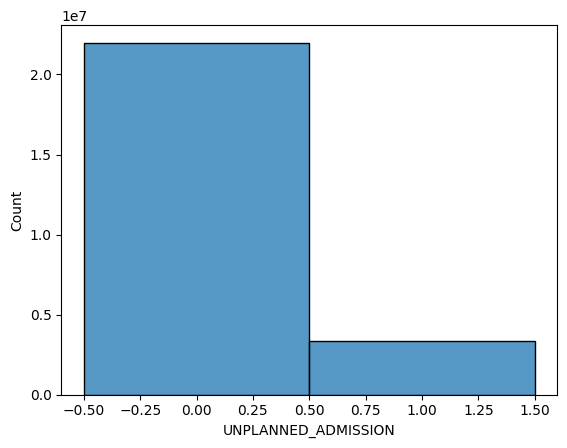

In [13]:
warnings.filterwarnings('ignore')
# Table showing distribution of outcome variable 
display(demo_df.stb.freq(['UNPLANNED_ADMISSION']))

# Histogram of outcome variable
sns.histplot(
    data=demo_df,
    x='UNPLANNED_ADMISSION',
    discrete=True,
    stat='count')


<a id="3b"></a>
### 2.2 Check Distributions of Demographic Variables

There are two numeric variables in the datasets: PARTD_18 and BENE_AGE.

[Text(0.5, 1.0, 'Age Distribution')]

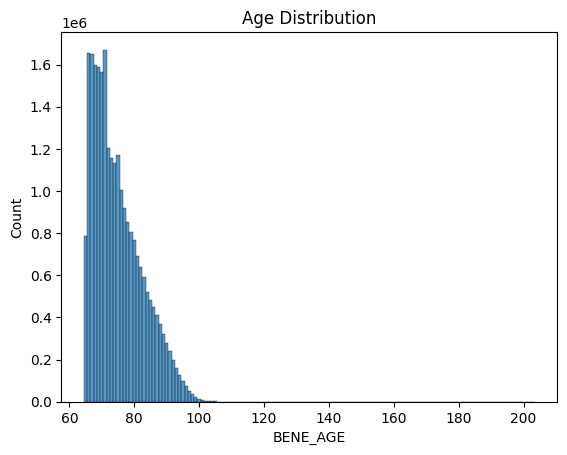

In [14]:
warnings.filterwarnings('ignore')
# Density Plot of BENE_AGE
age_plot = sns.histplot(
    data=demo_df,
    x='BENE_AGE',
    discrete=True,
    stat='count').set(title='Age Distribution')

display(age_plot)


[Text(0.5, 1.0, 'Part D enrollment(in months) Distribution')]

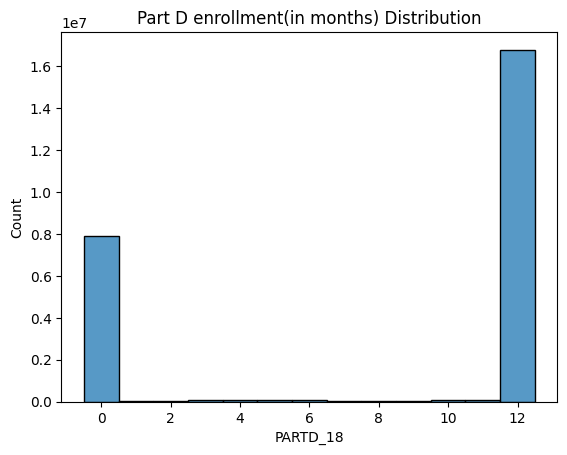

In [16]:
warnings.filterwarnings('ignore')
# Histogram of PARTD_18
partd_plot = sns.histplot(
    data=demo_df,
    x='PARTD_18',
    discrete=True,
    stat='count').set(title='Part D enrollment(in months) Distribution')
display(partd_plot)

We will also check the distributions of categorical variables to see if we need to combine any categories. 

In [17]:
display(demo_df.stb.freq(['BENE_RTI_RACE_CD']))
display(demo_df.stb.freq(['BENE_SEX_CD']))
display(demo_df.stb.freq(['LIS_STATUS']))
display(demo_df.stb.freq(['DUAL_STATUS']))
display(demo_df.stb.freq(['GEO_URBN_RRL_CD']))
display(demo_df.stb.freq(['PARTD_18']))

,BENE_RTI_RACE_CD,count,percent,cumulative_count,cumulative_percent
0,1,20763802,81.917366,20763802,81.917366
1,2,1767406,6.972771,22531208,88.890137
2,5,1275519,5.032178,23806727,93.922316
3,4,740035,2.919587,24546762,96.841902
4,0,465804,1.837690,25012566,98.679593
5,3,214698,0.847027,25227264,99.526619
6,6,119719,0.472315,25346983,99.998935
7,~,270,0.001065,25347253,100.000000


,BENE_SEX_CD,count,percent,cumulative_count,cumulative_percent
0,2,14177688,55.933824,14177688,55.933824
1,1,11062869,43.645238,25240557,99.579063
2,0,106696,0.420937,25347253,100.000000


,LIS_STATUS,count,percent,cumulative_count,cumulative_percent
0,False,24852441,98.047867,24852441,98.047867
1,True,494812,1.952133,25347253,100.000000


,DUAL_STATUS,count,percent,cumulative_count,cumulative_percent
0,False,22008569,86.828222,22008569,86.828222
1,True,3338684,13.171778,25347253,100.000000


,GEO_URBN_RRL_CD,count,percent,cumulative_count,cumulative_percent
0,U,18457079,72.816881,18457079,72.816881
1,R,6734809,26.570173,25191888,99.387054
2,UNKNOWN,155365,0.612946,25347253,100.000000


,PARTD_18,count,percent,cumulative_count,cumulative_percent
0,12,16776271,66.185756,16776271,66.185756
1,0,7900299,31.168265,24676570,97.354021
2,11,90089,0.355419,24766659,97.709440
3,6,75350,0.297271,24842009,98.006711
4,4,70401,0.277746,24912410,98.284457
5,10,64150,0.253085,24976560,98.537542
6,3,63590,0.250875,25040150,98.788417
7,5,59687,0.235477,25099837,99.023894
8,9,57265,0.225922,25157102,99.249816
9,7,52805,0.208326,25209907,99.458142


Based on the resulting distributions, we will change '~' in BENE_RTI_RACE_CD to '0' and transform PARD_18 into a boolean value. 


In [18]:
demo_df['BENE_RTI_RACE_CD'].replace('~','0',inplace=True)
demo_df['PARTD_18'] = demo_df['PARTD_18'].apply(lambda x: 0 if x>0 else 1).astype(bool)

There are several other variable exploration and plots you can create. This is just a small subset for the sake of a brief example. 

***

<a id="4"></a>
## **3.0 Defining Cohorts**

***

After examining the dataset in the previous section, we will now prepare the features for the classifier models to predict unplanned admissions. It is crucial to note that not all beneficiaries were enrolled in Part D in 2018. Therefore, when developing a model to predict unplanned inpatient admissions, we should create two separate models: one for beneficiaries with Part D benefits and one for beneficiaries not enrolled in Part D. This is because beneficiaries who are not enrolled in Part D benefits are getting their pharmacy benefits elsewhere and we don't have access to their data. 
- Cohort A: All Medicare beneficiaries over the age of 65 who are enrolled in Part A and Part B for at least one month in 2018
 - Cohort B: All Medicare beneficiaries over the age of 65 who are enrolled in Part A, Part B, and **Part D** for at least one month in 2018
 

The demographic variables are relatively simple to incorporate into a model (in the case of this example, where interaction terms and hierarchical are not considered for the sake of simplicity).  However, determining how to integrate diagnosis, procedure, and drug codes requires more consideration. One approach is to include the raw codes in a model and choose a model type that will automatically select the most relevant ones for us. Alternatively, to make the model more interpretable, we can perform feature engineering by grouping these codes into categories. There are various options for this, ranging from clinically informed groupings to using an autoencoder. For this preliminary example, we will group our clinical variables as follows:
- Convert the ICD-10-CM codes into ICD-10 chapters
- Use BETOS procedure grouping 
- Use drug classes instead of NDCs

Note- Reference `cohort_outcome_clinical_elements_selection.ipynb` to see which crosswalks were used


NOTE - these categories were chosen because they strike a balance between simplicity and widely used, clinically informed groups. However, it is advisable to explore multiple types of groupings and evaluate various methods to achieve the best results.

Each of the cohort datasets will contain the **same demographic variables**, but **differ in regard to the types of diagnosis, procedure, and drug variables**.

Thus, we will use four datasets for our preliminary modeling: 

**Table: Cohort Descriptions**


| **Dataset Type** | **Population**  | **Variables**  |
| --- | --- | --- |
| Cohort A (raw codes) |  Part A and Part B Medicare beneficiaries |  Demographic Variables <br> ICD-10-CM diagnosis codes <br> HCPCS Procedure codes|
| Cohort A (clinically informed groupings of raw codes) |  Part A, Part B beneficiaries|  Demographic Variables <br> ICD-10-CM chapter categories <br> BETOS Groupings|
| Cohort B (raw codes) |  Part A, Part B and Part D Medicare beneficiaries |  Demographic Variables <br> ICD-10-CM diagnosis codes <br> HCPCS Procedure codes <br> National Drug Codes(NDC)|
| Cohort B (clinically informed groupings of raw codes) |  Part A, Part B, and Part D beneficiaries|  Demographic Variables <br> ICD-10-CM chapter categories <br> BETOS Groupings <br> USP Drug Classes|


For the sake of this example, we are going to model with a 2 million sample. 

In [62]:
demo_df_samp = demo_df.sample(n=2000000, random_state= 42)

cohort_a = demo_df_samp.merge(dx_df, on="BENE_SK", how = "left").merge(proc_df, on="BENE_SK", how = "left")
cohort_b = cohort_a.merge(rx_df, on="BENE_SK", how = "left")[cohort_a['PARTD_18']>0]

Let's conduct a quick memory check. 

In [20]:
print("Percent of RAM used")
print(psutil.virtual_memory().percent)

print("Percent of RAM left")
print(psutil.virtual_memory().available * 100 / psutil.virtual_memory().total)

Percent of RAM used
31.6
Percent of RAM left
68.39757026607485


We will remove the source files since the cohorts are created. 

In [ ]:
del demo_df
del rx_df
del dx_df
del proc_df

***

<a id="5"></a>
## **4.0 Modeling - Example with Cohort A: Raw Codes**

***

<a id="5a"></a>
### **4.1**: Logistic Models

Note: In this notebook, we report results using a sample size of n=2,000,000. Other results presented in slide form for this work used a smaller subset of the full dataset where n=1,000,000.

***

<a id="5aa"></a>
### 4.1.1 **Baseline Logistic Model**

<a id="5aaa"></a>
#### 4.1.1.a **Data Preparation** 

We will run a logistic regression to see how a simple classifier model behaves on Cohort A: raw codes as a sanity check. For this purpose, the dataset is temporarily split into training/test sets.

We must transform the data into an `X` matrix containing all the predictor variables and a `y` matrix containing the outcome variable, aka **unplanned admission**.Since the dataset is so large, we will be using **sparse matrices** created by the DictVectorizer() function to create the `X` matrix. Sparse matrices provide efficient storage for datasets containing a large number of binary predictors. Each row of the matrix  will hold only the non-zero variables for each beneficiary.

As seen in the image below, the dense matrix stores information about all the 0 value variables, which is really inefficient. If we use the sparse matrices, we can run models with less memory resulting in faster results. This is especially important for large datasets.

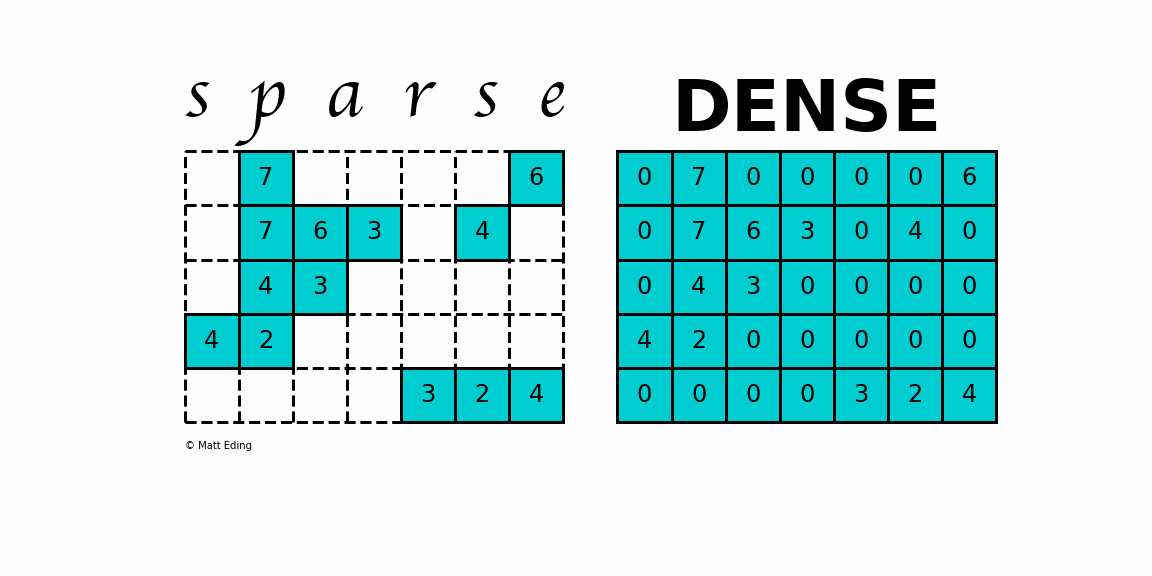

`Credit to Matt Edding (Python & Data Science Blog)` -https://matteding.github.io/2019/04/25/sparse-matrices/

Currently, the DX_ARRAY and PROC_ARRAY columns are arrays of codes stored in strings. We have to modify the _ARRAY columns by creating a key value pair for each value in the columns, so a sparse matrix can be created for each of the rows in the dataset. 

In [21]:
# Fix the array column such that each row holds a dictionary of unique values
def create_dict (record_data,array_vars):
      D = [{**{code: 1 for col in array_vars for code in row[col]},
            'BENE_AGE': row['BENE_AGE'],
            'BENE_RTI_RACE_CD': row['BENE_RTI_RACE_CD'],
            'BENE_SEX_CD': row['BENE_SEX_CD'],
            'LIS_STATUS': row['LIS_STATUS'],
            'DUAL_STATUS': row['DUAL_STATUS'],
            'PARTD_18': row['PARTD_18'],
            'GEO_URBN_RRL_CD': row['GEO_URBN_RRL_CD'],} for row in record_data]
      return(D)

The `DictVectorizer()` function transforms mappings (or dictionaries) of feature names into dense or sparse arrays for use for sckikit-learn functions.The `DictVectorizer()` function will also do conduct a binary one-hot encoding: one boolean-valued feature is constructed for each of the possible string values that the feature can take on. So, there is no need to transform our categorical variables into boolean variables before running the function. 

It's important to note, this just one way to transform the data for modeling efforts for use of function in the sckikit-learn library.

In [22]:
# Function to transform the pandas dataframe into a sparse matrix
def process_data_for_model(df,array_vars):

    # Fill empty rows with empty lists 
    df[array_vars] = df[array_vars].fillna('[]') 
    
    # Convert DX_ARRAY and BETOS_ARRAY to lists
    df[array_vars] = df[array_vars].applymap(ast.literal_eval) 

    # Split the data
    X = df.loc[:, df.columns != 'UNPLANNED_ADMISSION']
    y = df['UNPLANNED_ADMISSION']
    
    X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
    
    # Convert the DataFrame to a list of dictionaries using 'records' orientation
    train_records = X_train_raw.to_dict('records')
    test_records = X_test_raw.to_dict('records')

    # Clean up dict's to feed into the sparse matrix 
    D_train = create_dict (train_records,array_vars)
    D_test = create_dict (test_records,array_vars)
   
    # Calling fit_transform on the test data will re-create the mapping between the features and columns 
    dv = DictVectorizer(sparse=True)
    X_train = dv.fit_transform(D_train)
    X_test = dv.transform(D_test)

    return X_train, y_train, X_test, y_test,dv

In [23]:
# Drop the clinically informed groupings from the dataset 
cohort_a_raw = cohort_a.drop(['BETOS_ARRAY','DX_SUBGRP_ARRAY','BENE_SK'], axis=1, inplace = False)

As mentioned before, the demographic variables will stay consistent for each of the cohorts. Below are the clinical variables in the Cohort A: raw codes group. 



| **Clinical Variable** | **Definition**  | 
| --- | --- | 
| ICD-10 CM diagnosis codes  </span>| An array of ICD-10 diagnosis codes in 2018|
|   Healthcare Common Procedure Coding System (HCPCS) procedure codes </span>| An array of HCPCS procedure codes in 2018  |

Now, we will run the process_data_for_model() function to turn the dataset into a  `X` sparse matrix containing all the predictor variables and a `y` matrix containing the outcome variable.Each row of the matrix will hold only the non-zero variables for each beneficiary.

In [24]:
array_vars =['DX_ARRAY','PROC_ARRAY']
X_train, y_train, X_test, y_test, dv = process_data_for_model(cohort_a_raw,array_vars)

Now, we can move onto modeling!

<a id="5aab"></a>
#### 4.1.1.b **Baseline Logistic Regression**

We will illustrate a `logistic model`  using the package **scikit-learn** which belong to the generalized linear model (GLM) family. The purpose of this model is to obtain a baseline.

In [38]:
baseline_logistic = SGDClassifier(max_iter =10000,alpha = 0.1,loss='log_loss').fit(X_train, y_train)

When evaluating a model, it's important to select metrics to assess predictive ability, generalization capability, and overall quality. Now that we have run the baseline model, we will evaluate both on the following metrics:
- **AUC** : Stands for "Area under the ROC Curve."  AUC measures the entire two-dimensional area underneath the entire ROC curve, which is the performance of a classification model at all classification thresholds, so higher values are better. 
- **Recall**: The Ratio of the correct predictions and the total number of correct items in the set. Recall tells us how good the model is at correctly predicting unplanned admissions. 
- **Precision**: The ratio between the correct predictions and the total predictions. Precision tells us the quality of the model's positive predictions of unplanned admissions. 
- **F-1 Score**: A measure of how well the model balances between  recall and precision.

These metrics are optimal for situations where there is imbalanced data. For example, even though accuracy (the number of correct predictions divided by the total number of predictions) is a standard metric for model evaluation, it's less useful for our situation. 

For example, about 87% of beneficiaries do not have an unplanned admission. So, if we build a model that predicts every beneficiary **does not** have an unplanned admission, the model would have an accuracy of 87% which is misleading. 

These are just four example of metrics. The choice of evaluation metrics depends on the specific problem domain, the type of data, and the desired outcome which will differ. NOTE -  this is just an example showing how to pick a few metrics and check for a basic model. 

In [26]:
# Calculates preformance metrics and returns a table
def model_preformance (model_name,model,X_test, y_test):
    predictions = model.predict(X_test)
    predicted_proba = model.predict_proba(X_test)

    auc = roc_auc_score(y_test, predicted_proba[:, -1])
    recall = recall_score(y_test, predictions)
    precision= precision_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)

    df = pd.DataFrame({
        "Model" : [model_name],
        "AUC": [auc],
        "Recall": [recall],
        "Precision":[precision],
        "F-1 Score":[f1]
    })

    return(df)

In [41]:
model_preformance("Baseline Logistic Regression",baseline_logistic, X_test, y_test)

,Model,AUC,Recall,Precision,F-1 Score
0,Baseline Logistic Regression,0.700472,0.057012,0.628304,0.104538


<a id="5ab"></a>
#### 4.1.2 **Regularized Logistic Model**

Linear models (LMs) are a simple yet powerful approach to predictive modeling.  **Regularization** methods provide a means to constrain or regularize the estimated coefficients, which can reduce the variance and decrease out of sample error.

Regularization techniques, such as L1 (Lasso) and L2 (Ridge) regularization, add a penalty term to the objective function of the logistic model, which discourages the model from using too many predictors or assigning large weights to the predictors. This helps to address the above challenges: 

1. Prevent overfitting: Regularization penalizes large weights, resulting in a simpler and more robust model that is less likely to overfit the training data. 

2. Handle multicollinearity: Regularization can help to deal with correlated predictors by distributing weights among them or eliminating some of the less important ones (in the case of L1 regularization). 

3. Encourage sparsity: L1 regularization, in particular, tends to produce sparse models by driving some predictor weights to zero, effectively performing feature selection. This can be beneficial when dealing with high-dimensional datasets with many irrelevant or redundant predictors. By using regularized logistic models, you can improve the model's performance on high-dimensional datasets by addressing overfitting, handling multicollinearity, and encouraging sparsity in the model.

We will illustrate a `regularized logistic model`  using the package **scikit-learn** which belong to the generalized linear model (GLM) family. We will use a random grid search, which is  a technique for hyperparameter tuning of machine learning models. Instead of exhaustively trying all possible combinations of hyperparameter values in a grid (as in GridSearchCV), RandomizedSearchCV randomly samples a subset of hyperparameter combinations to train and validate the model. This method can be more efficient than the exhaustive grid search, as it allows you to specify the number of iterations or combinations to try, reducing the computational cost. It also has the potential to find good hyperparameter values even with a small number of iterations due to the randomness, which can help in avoiding local optima.

Since the data is imbalanced, we will also test if using balanced weights improved the model. Of course, there are several other options such as down-sampling that can also be used, this is just an example of one option. 


Selecting parameters for a grid search involves choosing the hyperparameters and their corresponding values that you want to tune for a given machine learning model. When using grid search, you should carefully select the hyperparameters as the search space grows exponentially with the number of hyperparameters and their possible values. 

In [42]:
def best_regularization_model(X_train,y_train):
    # specify parameter ranges
    alpha=[0.00001,0.0001,0.001,0.01,0.1,0.5,1,5]
    penalty = ['l1', 'l2']
    class_weight=['balanced',None]
    hyperparameters = dict(alpha=alpha,penalty=penalty,class_weight=class_weight)

    sgd = SGDClassifier(max_iter =1000,loss='log_loss')
    randomizedsearch = RandomizedSearchCV(sgd, hyperparameters,scoring= 'average_precision', random_state=42, cv=2, n_jobs=-1)
    best_model_random = randomizedsearch.fit(X_train, y_train)
    return(best_model_random)

In [43]:
best_model =best_regularization_model(X_train,y_train)

Let's evaluate the model and compare to the baseline.

In [44]:
baseline_eval = model_preformance("Baseline Regression Model",baseline_logistic, X_test, y_test)
best_eval = model_preformance("Best Parameters Ridge Regression Model",best_model, X_test, y_test)

cohort_a_raw_eval = pd.concat([baseline_eval,best_eval],axis = 0, ignore_index = True)
display(cohort_a_raw_eval)

,Model,AUC,Recall,Precision,F-1 Score
0,Baseline Regression Model,0.700472,0.057012,0.628304,0.104538
1,Best Parameters Ridge Regression Model,0.777767,0.634249,0.307086,0.413814


Since the best model is a lasso regression, we will try running a ridge but keep all the same parameters. 

In [45]:
# Set up logic to select the opposite penalty 
if best_model.best_estimator_.penalty:
    penalty = 'l2'
else: 
   penalty = 'l1'
    

other_best_model= SGDClassifier(max_iter =1000,
                                loss='log_loss',
                                alpha= best_model.best_estimator_.alpha,
                                class_weight=best_model.best_estimator_.class_weight,
                                penalty = penalty).fit(X_train, y_train)

Let's compare all three models.

In [46]:
# Table of evaluation metrics
if penalty =='l1':
    other_model_name = "Ridge Regression Model"
    best_model_name = "Lasso Regression Model"
else: 
    other_model_name = "Lasso Regression Model"
    best_model_name = "Ridge Regression Model"


baseline_eval = model_preformance("Baseline Regression Model",baseline_logistic ,X_test, y_test)
best_eval= model_preformance(f"Best Parameters {best_model_name}",best_model, X_test, y_test)
other_best_eval= model_preformance(f"Best Parameters {other_model_name}",other_best_model, X_test, y_test)


cohort_a_raw_eval = pd.concat([baseline_eval,best_eval,other_best_eval],axis = 0, ignore_index = True)
display(cohort_a_raw_eval)

,Model,AUC,Recall,Precision,F-1 Score
0,Baseline Regression Model,0.700472,0.057012,0.628304,0.104538
1,Best Parameters Ridge Regression Model,0.777767,0.634249,0.307086,0.413814
2,Best Parameters Lasso Regression Model,0.777382,0.620501,0.312921,0.416035


As we can see, the regularization models preformed better than the baseline. This makes sense because regularization helps to prevent overfitting, reduce model complexity, and improve generalization. In high-dimensional datasets with thousands of variables (also known as features or predictors), some challenges arise: 

1. Overfitting: With a large number of predictors, models tend to capture noise in the data and fit too closely to the training set, leading to poor performance on new, unseen data. 

2. Multicollinearity: High-dimensional datasets often have correlated variables, which can make it difficult for the model to assign appropriate weights to each predictor and may lead to unstable estimates.

 3. Sparse data: In some cases, high-dimensional datasets can be sparse, meaning that many predictors have zero or very few non-zero values, making it difficult for models to capture meaningful patterns.
 





<a id="5b"></a>
### **4.2**: XGBOOST Model

XGBoost (eXtreme Gradient Boosting) is an advanced implementation of the gradient boosting algorithm, which is an ensemble learning technique that builds a series of decision trees sequentially, with each tree learning from the mistakes of the previous one.

 XGBoost performs well with data with thousands of variables for several reasons: 
 
 1. Regularization: XGBoost incorporates L1 (Lasso) and L2 (Ridge) regularization in its objective function, which helps to prevent overfitting and improve generalization, especially when dealing with high-dimensional datasets.
 
2. Sparsity-aware algorithm: XGBoost can efficiently handle sparse data and missing values, thanks to its sparsity-aware algorithm. It can automatically learn the best strategy for handling missing values and exploit the sparsity pattern in the data, which is beneficial when dealing with high-dimensional datasets with many zero or missing values. 

3. Column block and parallelization: XGBoost uses a column block structure to store the data, which allows it to perform parallel computation and cache-aware access patterns. This enables XGBoost to efficiently handle large datasets with thousands of variables and scale to a large number of CPU cores or distributed computing environments. 

4. Feature selection: XGBoost can perform built-in feature selection by calculating feature importance scores, which can be used to identify and remove irrelevant or redundant predictors. This helps to reduce the model complexity and improve performance when dealing with high-dimensional data. 

5. Flexibility: XGBoost allows for customization of the learning process, such as defining custom loss functions and evaluation metrics, which can help to adapt the model to specific problems and datasets. 

6. Robustness to noisy data: Gradient boosting algorithms, in general, are robust to noisy data and outliers, which can be beneficial when dealing with high-dimensional datasets that may contain noisy or irrelevant predictors. 

XGboost is by far the most popular gradient boosted trees implementation. It is excellent for high dimensional data, therefore we will test out this model on our Cohort A: feature set with raw codes. 

We will use a sample of the training data to run on the random grid search to find the best parameters. We will include a weighting variable as well to handle the imbalanced data.

In [47]:
def best_xgboost(X_train,y_train):
# Use a random grid search to find the best values
    classifier = xgboost.XGBClassifier()
    # the weight option should be: neg_instances/pos_instances
    pos_instances = np.sum(~y_train)
    neg_instances  = np.sum(y_train)
    weight = neg_instances/pos_instances
    
    params = {
    "learning_rate" : [0.05,0.10,0.15,0.20,0.25,0.30],
    "max_depth" : [ 3, 4, 5, 6, 8, 10, 12, 15],
    "min_child_weight" : [ 1, 3, 5, 7 ],
    "gamma": [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
    "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ],
    'scale_pos_weight':[weight,1]
    }
        
    # Split the dataset into a smaller subset for hyperparameter optimization (25% of the original data)
    X_opt,_, y_opt,_= train_test_split(X_train, y_train, test_size=0.75, random_state=42,stratify=y_train)

    # Train the best XGBoost model 
    randomizedsearch=RandomizedSearchCV(classifier,param_distributions=params,n_iter=5,scoring='f1_macro',n_jobs=-1,cv=2,verbose=0)
    best_model_random = randomizedsearch.fit(X_opt, y_opt)
    
    # Train the model on the entire training set
    best_xgboost = best_model_random.best_estimator_
    best_xgboost.fit(X_train, y_train)

    return(best_xgboost)

In [48]:
xgboost = best_xgboost(X_train,y_train);

<a id="5c"></a>
### **4.3**: Compare Models

Now, we will compare all four models.

In [49]:
if penalty =='l1':
    other_model_name = "Ridge Regression Model"
    best_model_name = "Lasso Regression Model"
else: 
    other_model_name = "Lasso Regression Model"
    best_model_name = "Ridge Regression Model"


baseline_eval_a_raw = model_preformance("Baseline Regression Model",baseline_logistic ,X_test, y_test)
best_eval_a_raw= model_preformance(f"Best Parameters {best_model_name}",best_model, X_test, y_test)
other_best_eval_a_raw = model_preformance(f"Best Parameters {other_model_name}",other_best_model, X_test, y_test)
xgboost_a_raw =  model_preformance("XGBoost Model",xgboost ,X_test, y_test)

result = pd.concat([baseline_eval_a_raw,best_eval_a_raw,other_best_eval_a_raw,xgboost_a_raw],axis = 0, ignore_index = True)
display(result)

,Model,AUC,Recall,Precision,F-1 Score
0,Baseline Regression Model,0.700472,0.057012,0.628304,0.104538
1,Best Parameters Ridge Regression Model,0.777767,0.634249,0.307086,0.413814
2,Best Parameters Lasso Regression Model,0.777382,0.620501,0.312921,0.416035
3,XGBoost Model,0.789412,0.137270,0.588107,0.222586


Lastly, we will evalute the recall-precision and ROC curves for all four models.

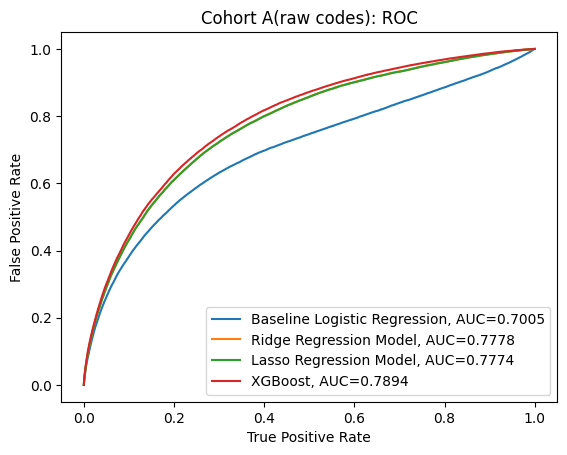

In [50]:
# Show the ROC for all three models 
#set up plotting area
plt.figure(0).clf()

# Baseline Logistic Regression
y_pred = baseline_logistic.predict_proba(X_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
auc = round(metrics.roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="Baseline Logistic Regression, AUC="+str(auc))

# Best Parameters Logistic Regression
y_pred = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
auc = round(metrics.roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label=f"{best_model_name}, AUC="+str(auc))

# Other best Parameters Logistic Regression
y_pred = other_best_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
auc = round(metrics.roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label=f"{other_model_name}, AUC="+str(auc))

# XGBoost
y_pred = xgboost.predict_proba(X_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
auc = round(metrics.roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="XGBoost, AUC="+str(auc))


plt.xlabel("True Positive Rate")
plt.ylabel("False Positive Rate")

plt.title("Cohort A(raw codes): ROC")
#add legend
plt.legend()

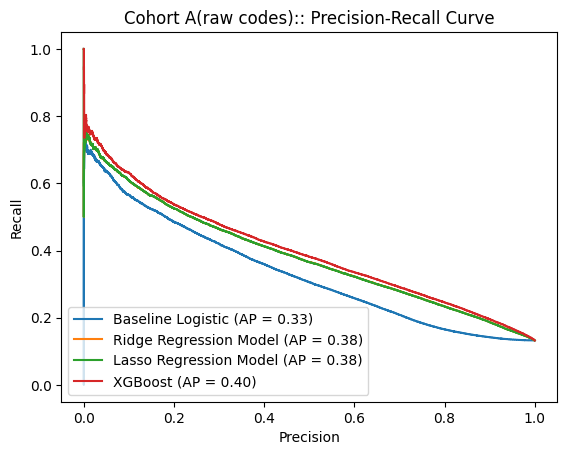

In [51]:
# Plot precision recall curves
fig, ax = plt.subplots()

PrecisionRecallDisplay.from_estimator(baseline_logistic, X_test, y_test, name="Baseline Logistic", plot_chance_level=False,ax=ax)
PrecisionRecallDisplay.from_estimator(best_model, X_test, y_test, name=f"{best_model_name}", plot_chance_level=False,ax=ax)
PrecisionRecallDisplay.from_estimator(other_best_model, X_test, y_test, name=f"{other_model_name}", plot_chance_level=False,ax=ax)
PrecisionRecallDisplay.from_estimator(xgboost, X_test, y_test, name="XGBoost", plot_chance_level=False,ax=ax)


plt.xlabel("Precision")
plt.ylabel("Recall")

plt.title("Cohort A(raw codes):: Precision-Recall Curve")

plt.show()

In summary, regularized logistic regression and XGBoost models often outperform regular logistic regression in classification tasks due to their ability to reduce overfitting, perform feature selection, handle missing values, and incorporate regularization. Additionally, XGBoost's ensemble learning approach and scalability make it a powerful tool for building accurate and robust classification models.

***

<a id="6"></a>
## **5**: Run models for all Cohorts

Now, we will run the same set of models for the other cohorts, except we will only include XBGoost models for the raw codes cohorts. We will  utilize functions created in section 4 to run and evaluate the models.
- Cohort A: Clinically Informed Groupings of Codes
- Cohort B: Raw codes
- Cohort B: Clinically Informed Groupings of Codes

<a id="6a"></a>
### **5.1**: Cohort A: Clinically Informed Groupings of Codes

In [52]:
del X_train
del y_train
del X_test
del y_test
del dv

del baseline_logistic
del best_model
del other_best_model
del xgboost


Here are the clinical variables in the Cohort A: groupings cohort. 


| **Clinical Variable - Grouped** | **Definition**  | **Values**  |
| --- | --- | --- |
|  ICD-10 Chapters </span>| An array of  ICD-10-CM chapters derived from 2018 ICD-10-CM codes| string |
|  Berenson-Eggers Type of Service (BETOS) Codes </span>| An array of BETOS procedure codes derivied from HCPCS procedure codes | string |

In [63]:
cohort_a_grouped = cohort_a.drop(['PROC_ARRAY','DX_ARRAY','BENE_SK'], axis=1, inplace = False)

In [64]:
array_vars =  ['DX_SUBGRP_ARRAY', 'BETOS_ARRAY']
X_train, y_train, X_test, y_test, dv = process_data_for_model(cohort_a_grouped,array_vars)

In [65]:
## Logistic regression models
baseline_logistic = SGDClassifier(max_iter =10000,loss='log_loss').fit(X_train, y_train)
best_model=  best_regularization_model(X_train,y_train)

# Set up logic to select the opposite penalty 
# Set up logic to select the opposite penalty 
if best_model.best_estimator_.penalty:
    penalty = 'l2'
else: 
   penalty = 'l1'
    

other_best_model= SGDClassifier(max_iter =1000,
                                loss='log_loss',
                                alpha= best_model.best_estimator_.alpha,
                                class_weight=best_model.best_estimator_.class_weight,
                                penalty = penalty).fit(X_train, y_train)

In [71]:
# Table of evaluation metrics
if penalty =='l1':
    other_model_name = "Ridge Regression Model"
    best_model_name = "Lasso Regression Model"
else: 
    other_model_name = "Lasso Regression Model"
    best_model_name = "Ridge Regression Model"


baseline_eval_a_grouped = model_preformance("Baseline Regression Model",baseline_logistic ,X_test, y_test)
best_eval_a_grouped = model_preformance(f"Best Parameters {best_model_name}",best_model, X_test, y_test)
other_best_eval_a_grouped = model_preformance(f"Best Parameters {other_model_name}",other_best_model, X_test, y_test)


cohort_a_grouped_eval = pd.concat([baseline_eval_a_grouped,best_eval_a_grouped,other_best_eval_a_grouped],axis = 0, ignore_index = True)
display(cohort_a_grouped_eval)

,Model,AUC,Recall,Precision,F-1 Score
0,Baseline Regression Model,0.769844,0.239094,0.451453,0.312621
1,Best Parameters Ridge Regression Model,0.752230,0.657042,0.262926,0.375564
2,Best Parameters Lasso Regression Model,0.753667,0.698550,0.248579,0.366676


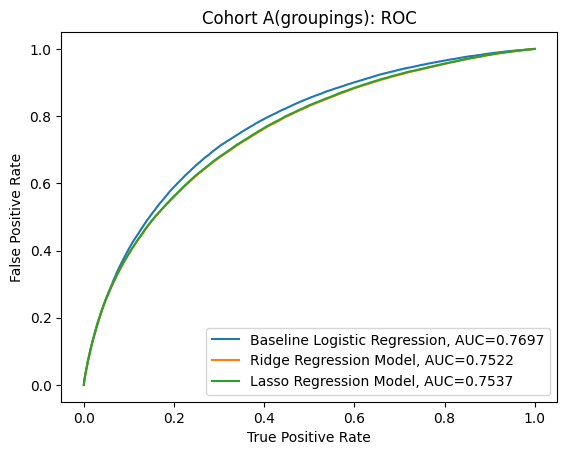

In [67]:
# Show the ROC for all three models 
#set up plotting area
plt.figure(0).clf()

# Baseline Logistic Regression
y_pred = baseline_logistic.predict_proba(X_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
auc = round(metrics.roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="Baseline Logistic Regression, AUC="+str(auc))

# Best Parameters Logistic Regression
y_pred = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
auc = round(metrics.roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label=f"{best_model_name}, AUC="+str(auc))

# Other best Parameters Logistic Regression
y_pred = other_best_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
auc = round(metrics.roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label=f"{other_model_name}, AUC="+str(auc))

plt.xlabel("True Positive Rate")
plt.ylabel("False Positive Rate")

plt.title("Cohort A(groupings): ROC")
#add legend
plt.legend()

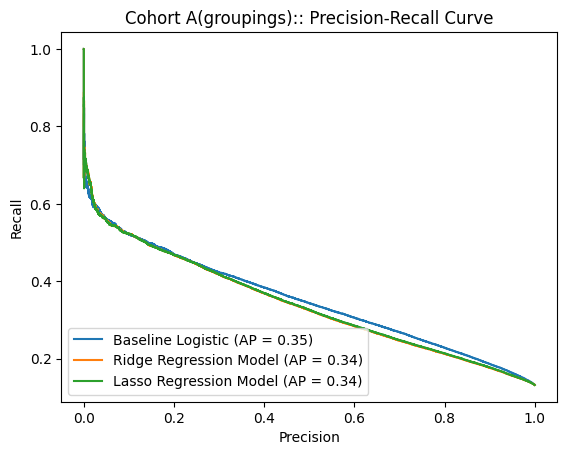

In [68]:
# Plot precision recall curves
fig, ax = plt.subplots()

PrecisionRecallDisplay.from_estimator(baseline_logistic, X_test, y_test, name="Baseline Logistic", plot_chance_level=False,ax=ax)
PrecisionRecallDisplay.from_estimator(best_model, X_test, y_test, name=f"{best_model_name}", plot_chance_level=False,ax=ax)
PrecisionRecallDisplay.from_estimator(other_best_model, X_test, y_test, name=f"{other_model_name}", plot_chance_level=False,ax=ax)

plt.xlabel("Precision")
plt.ylabel("Recall")

plt.title("Cohort A(groupings):: Precision-Recall Curve")

plt.show()

As we can see, the regularization models perform similarly to regular logistic regression. This can happen when the dataset has only a few variables (features). When there are only a few variables in the dataset, the chances of overfitting and the need for feature selection are reduced. Consequently, the benefits of regularization in regularized logistic regression are not as pronounced. 

<a id="6c"></a>
### **5.2**: Cohort B: Raw Codes

In [72]:
del X_train
del y_train
del X_test
del y_test
del dv

del baseline_logistic
del best_model
del other_best_model

Here are the variables for Cohort B: Raw Codes:


| **Clinical Variable - Grouped** | **Definition**  | **Values**  |
| --- | --- | --- |
|  ICD-10 Chapters </span>| An array of  ICD-10-CM chapters derived from 2018 ICD-10-CM codes| string |
|  Berenson-Eggers Type of Service (BETOS) Codes </span>| An array of BETOS procedure codes derivied from HCPCS procedure codes | string |

In [73]:
cohort_b_raw = cohort_b.drop(['BETOS_ARRAY','DX_SUBGRP_ARRAY','CLASS_ARRAY','BENE_SK'], axis=1, inplace = False)

In [74]:
# Set up data for model
array_vars =['DX_ARRAY','NDC_ARRAY','PROC_ARRAY']
X_train, y_train, X_test, y_test, dv = process_data_for_model(cohort_b_raw,array_vars)

In [75]:
## Logistic regression models
baseline_logistic = SGDClassifier(max_iter =10000,alpha = 0.1,loss='log_loss').fit(X_train, y_train)
best_model=  best_regularization_model(X_train,y_train)

# Set up logic to select the opposite penalty 
# Set up logic to select the opposite penalty 
if best_model.best_estimator_.penalty:
    penalty = 'l2'
else: 
   penalty = 'l1'
    

other_best_model= SGDClassifier(max_iter =1000,
                                loss='log_loss',
                                alpha= best_model.best_estimator_.alpha,
                                class_weight=best_model.best_estimator_.class_weight,
                                penalty = penalty).fit(X_train, y_train)

In [78]:
# XGboost model 
xgboost = best_xgboost(X_train,y_train);

In [84]:
# Create table of metric results 
if penalty =='l1':
    other_model_name = "Ridge Regression Model"
    best_model_name = "Lasso Regression Model"
else: 
    other_model_name = "Lasso Regression Model"
    best_model_name = "Ridge Regression Model"


baseline_eval_b_raw = model_preformance("Baseline Regression Model",baseline_logistic ,X_test, y_test)
best_eval_b_raw = model_preformance(f"Best Parameters {best_model_name}",best_model, X_test, y_test)
other_best_eval_b_raw = model_preformance(f"Best Parameters {other_model_name}",other_best_model, X_test, y_test)
xgboost_eval_b_raw =model_preformance("Best Parameters XGBoost",xgboost, X_test, y_test)

cohort_b_raw_eval = pd.concat([baseline_eval_b_raw,best_eval_b_raw,other_best_eval_b_raw,xgboost_eval_b_raw],axis = 0, ignore_index = True)
display(cohort_b_raw_eval)

,Model,AUC,Recall,Precision,F-1 Score
0,Baseline Regression Model,0.674787,0.025163,0.622642,0.048371
1,Best Parameters Ridge Regression Model,0.778176,0.538542,0.326799,0.406765
2,Best Parameters Lasso Regression Model,0.777224,0.497990,0.344226,0.407072
3,Best Parameters XGBoost,0.785914,0.135034,0.526771,0.214964


Now, let's check out the ROC curves and the recall-precision.

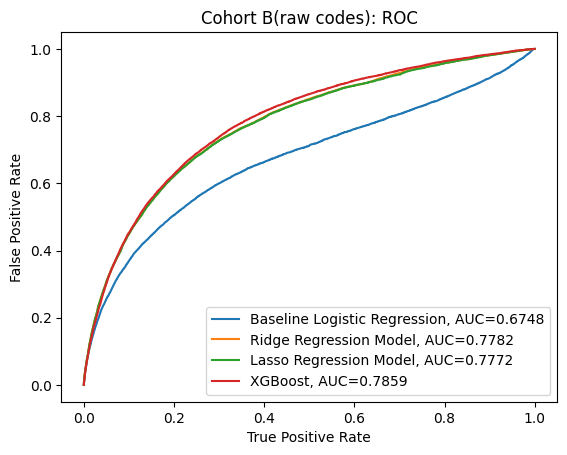

In [86]:
# Show the ROC for all three models 
#set up plotting area
plt.figure(0).clf()

# Baseline Logistic Regression
y_pred = baseline_logistic.predict_proba(X_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
auc = round(metrics.roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="Baseline Logistic Regression, AUC="+str(auc))

# Best Parameters Logistic Regression
y_pred = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
auc = round(metrics.roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label=f"{best_model_name}, AUC="+str(auc))

# Lasso Parameters Logistic Regression
y_pred = other_best_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
auc = round(metrics.roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label=f"{other_model_name}, AUC="+str(auc))

# XGBoost
y_pred = xgboost.predict_proba(X_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
auc = round(metrics.roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="XGBoost, AUC="+str(auc))


plt.xlabel("True Positive Rate")
plt.ylabel("False Positive Rate")

plt.title("Cohort B(raw codes): ROC")
#add legend
plt.legend()

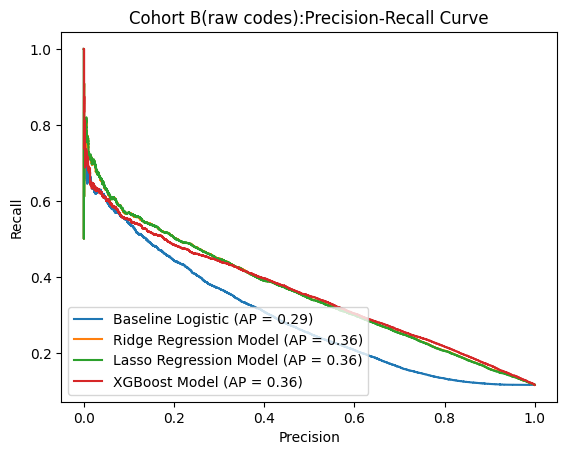

In [87]:
# Plot precision recall curves
fig, ax = plt.subplots()

PrecisionRecallDisplay.from_estimator(baseline_logistic, X_test, y_test, name="Baseline Logistic", plot_chance_level=False,ax=ax)
PrecisionRecallDisplay.from_estimator(best_model, X_test, y_test, name=f"{best_model_name}", plot_chance_level=False,ax=ax)
PrecisionRecallDisplay.from_estimator(other_best_model, X_test, y_test, name=f"{other_model_name}", plot_chance_level=False,ax=ax)
PrecisionRecallDisplay.from_estimator(xgboost, X_test, y_test, name="XGBoost Model", plot_chance_level=False,ax=ax)


plt.xlabel("Precision")
plt.ylabel("Recall")

plt.title("Cohort B(raw codes):Precision-Recall Curve")

plt.show()

<a id="6d"></a>
#### **5.3**: Cohort B: Clinically Informed Groupings of Codes

In [ ]:
del X_train
del y_train
del X_test
del y_test
del dv

del baseline_logistic
del best_model
del other_best_model
del xgboost

Here are the clinical variables for Cohort B (grouped codes):


| **Clinical Variable - Grouped** | **Definition**  | **Values**  |
| --- | --- | --- |
|  ICD-10 Chapters </span>| An array of  ICD-10-CM chapters derived from 2018 ICD-10-CM codes| string |
|  Berenson-Eggers Type of Service (BETOS) Codes </span>| An array of BETOS procedure codes derivied from HCPCS procedure codes | string |
| Drug Classes </span>| An array of drug classes from NDC's| string |

In [94]:
cohort_b_grouped = cohort_b.drop(['PROC_ARRAY','DX_ARRAY','NDC_ARRAY','BENE_SK'], axis=1, inplace = False)

In [96]:
## Logistic regression models
baseline_logistic = SGDClassifier(max_iter =10000,loss='log_loss').fit(X_train, y_train)
best_model=  best_regularization_model(X_train,y_train)

# Set up logic to select the opposite penalty 
# Set up logic to select the opposite penalty 
if best_model.best_estimator_.penalty:
    penalty = 'l2'
else: 
   penalty = 'l1'
    

other_best_model= SGDClassifier(max_iter =1000,
                                loss='log_loss',
                                alpha= best_model.best_estimator_.alpha,
                                class_weight=best_model.best_estimator_.class_weight,
                                penalty = penalty).fit(X_train, y_train)

In [99]:
# Create table of metric results 
if penalty =='l1':
    other_model_name = "Ridge Regression Model"
    best_model_name = "Lasso Regression Model"
else: 
    other_model_name = "Lasso Regression Model"
    best_model_name = "Ridge Regression Model"


baseline_eval_b_grouped = model_preformance("Baseline Regression Model",baseline_logistic ,X_test, y_test)
best_eval_b_grouped = model_preformance(f"Best Parameters {best_model_name}",best_model, X_test, y_test)
other_best_eval_b_grouped = model_preformance(f"Best Parameters {other_model_name}",other_best_model, X_test, y_test)

cohort_b_grouped_eval = pd.concat([baseline_eval_b_grouped,best_eval_b_grouped,other_best_eval_b_grouped],axis = 0, ignore_index = True)
display(cohort_b_grouped_eval)

,Model,AUC,Recall,Precision,F-1 Score
0,Baseline Regression Model,0.771665,0.382920,0.367727,0.375170
1,Best Parameters Ridge Regression Model,0.756619,0.642590,0.244940,0.354683
2,Best Parameters Lasso Regression Model,0.754720,0.563011,0.273735,0.368370


Now, let's look at the ROC and precision recall curve

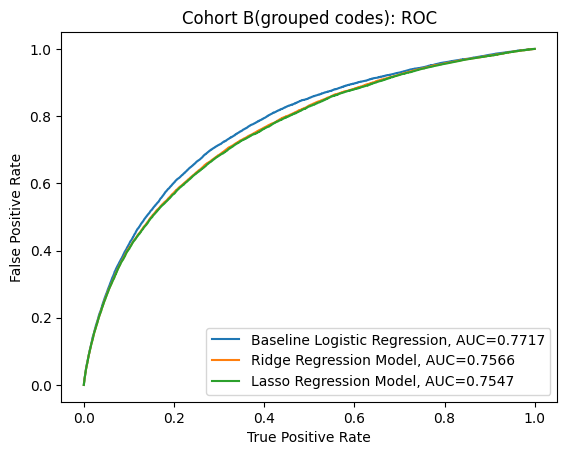

In [101]:
# Show the ROC for all three models 
#set up plotting area
plt.figure(0).clf()

# Baseline Logistic Regression
y_pred = baseline_logistic.predict_proba(X_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
auc = round(metrics.roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="Baseline Logistic Regression, AUC="+str(auc))

# Best Parameters Logistic Regression
y_pred = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
auc = round(metrics.roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label=f"{best_model_name}, AUC="+str(auc))

# Lasso Parameters Logistic Regression
y_pred = other_best_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
auc = round(metrics.roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label=f"{other_model_name}, AUC="+str(auc))

plt.xlabel("True Positive Rate")
plt.ylabel("False Positive Rate")

plt.title("Cohort B(grouped codes): ROC")
#add legend
plt.legend()

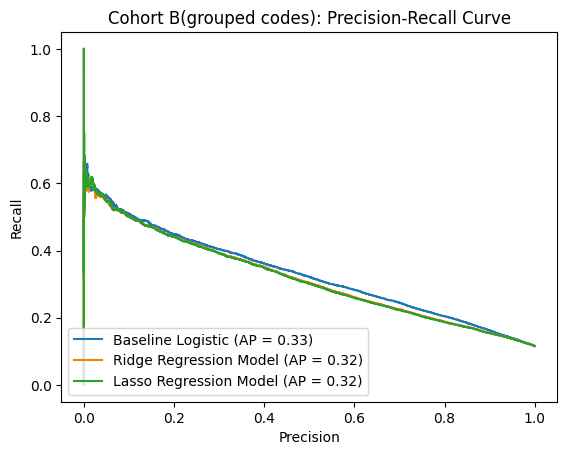

In [104]:
# Plot precision recall curves
fig, ax = plt.subplots()

PrecisionRecallDisplay.from_estimator(baseline_logistic, X_test, y_test, name="Baseline Logistic", plot_chance_level=False,ax=ax)
PrecisionRecallDisplay.from_estimator(best_model, X_test, y_test, name=f"{best_model_name}", plot_chance_level=False,ax=ax)
PrecisionRecallDisplay.from_estimator(other_best_model, X_test, y_test, name=f"{other_model_name}", plot_chance_level=False,ax=ax)

plt.xlabel("Precision")
plt.ylabel("Recall")

plt.title("Cohort B(grouped codes): Precision-Recall Curve")

plt.show()

<a id="6d"></a>
## **6**: Conclusion

This notebook demonstrates a simple example on how to use IDRC Medicare Claims data to model outcomes. Of course,  research is needed to explore the potential benefit of additional input variables, such as:
- Untouched clinical elements (e.g., number of prescribed medications)
- Other engineered feature sets (e.g., HCCs)
- Temporal data (e.g., number of ED visits in the past “X” months)

Futhermore, additional implicit and explicit bias mitigation strategies should be explored to assess equity: 
- Performance analysis by population subgroups including age, ethnicity, sex, sociodemographic stratum and location
- Engagement with Health equity SMEs
